# Face Detection and Clustering using GhostFaceNet

1. The objective of this notebook is to detect faces in images and cluster them based on the detected faces.
2. The faces will be extracted and put into a separate folder.

In [30]:
import os
import random
from tqdm import tqdm
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deepface import DeepFace

## Dataset

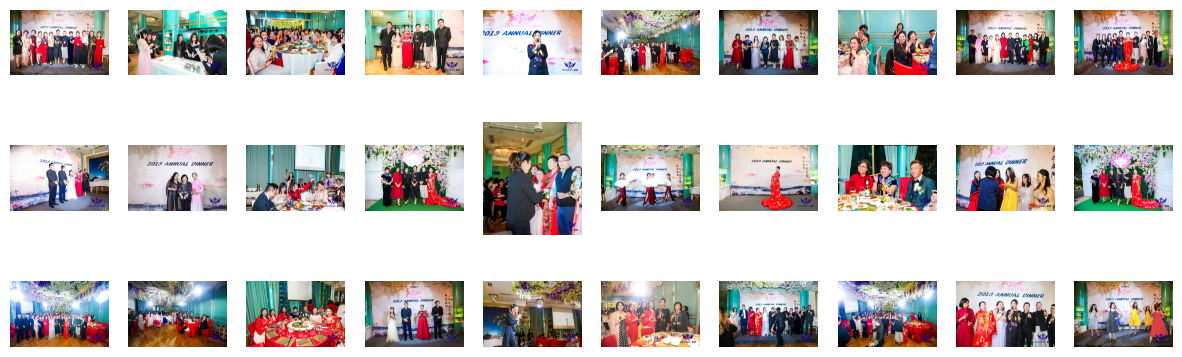

In [2]:
dataset_path = "dataset"

image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith(".jpg")]

random_images = random.sample(image_files, 30)
fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    image = Image.open(random_images[i])
    ax.imshow(image)
    ax.axis("off")
    
plt.show()

## Face Detection and Encoding

1. The goal of this section is to extract the faces in the images and encode them.
2. The face encoding will be used to cluster the faces.

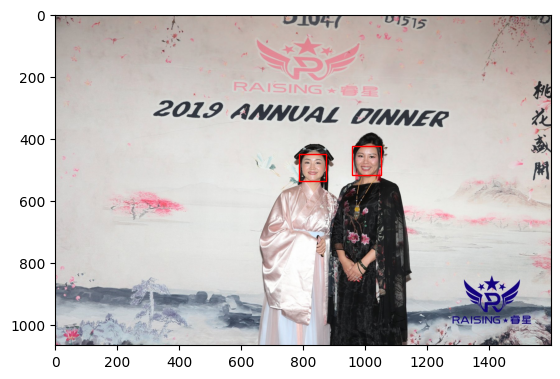

In [4]:
# Test for 1 image

img_path = dataset_path + "/0.jpg"
res = DeepFace.represent(img_path = img_path, model_name="GhostFaceNet")

# Plot the image and the rectangle of the face
fig, ax = plt.subplots()

image = Image.open(img_path)
ax.imshow(image)

for face in res:
    x, y, w, h, _, _ = face['facial_area'].values()
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
    ax.add_patch(rect)
    
plt.show()

### Extracting Faces from all image in dataset

The faces will be extracted from each image in the dataset and will be stored in a dataframe with below schema

| id | image_path | bounding_box | encoding |

In [17]:
def extract_faces(img_path: str, model_name: str = "GhostFaceNet") -> list:
    """
    Extracts faces from an image using a specified model.

    Args:
        img_path (str): The path to the image file.
        model_name (str): The name of the model to use for face extraction.

    Returns:
        list: A list of dictionaries containing the bounding box and embedding for each extracted face.
            - bounding_box (list): A list containing the bounding box coordinates of the face (x, y, w, h)
            - embedding (list): A list containing the embedding of the face. (size varies depending on the model)
    """
    
    try:
        res = DeepFace.represent(img_path = img_path, model_name=model_name)
    except:
        return []

    faces = []
    
    for face in res:
        x, y, w, h, _, _ = face['facial_area'].values()
        embedding = face['embedding']
        
        faces.append({
            'bounding_box': [x, y, w, h],
            'embedding': embedding
        })
        
    return faces

In [18]:
# Extract faces from the dataset

extracted_faces = {
    'img_path': [],
    'bounding_box': [],
    'embedding': []
}

uncessful_images = []

for filename in tqdm(os.listdir(dataset_path)):
    
    if filename.endswith(".jpg"):
        
        img_path = os.path.join(dataset_path, filename)
        faces = extract_faces(img_path)
        
        if faces == []:
            uncessful_images.append(filename)
            continue
        
        for face in faces:
            extracted_faces['img_path'].append(img_path)
            extracted_faces['bounding_box'].append(face['bounding_box'])
            extracted_faces['embedding'].append(face['embedding'])

100%|██████████| 672/672 [23:14<00:00,  2.08s/it] 


In [19]:
print("uncessful_images:", len(uncessful_images))

uncessful_images: 27


In [21]:
df = pd.DataFrame(extracted_faces)
df

,img_path,bounding_box,embedding
0,dataset/63.jpg,"[205, 378, 62, 62]","[-0.050344809889793396, 0.8437319397926331, 0...."
1,dataset/63.jpg,"[1364, 393, 63, 63]","[1.4465656280517578, 2.124927043914795, 0.8046..."
2,dataset/63.jpg,"[1235, 421, 53, 53]","[-0.6851216554641724, 1.3791860342025757, 2.03..."
3,dataset/63.jpg,"[718, 420, 56, 56]","[-1.0279676914215088, 0.16920658946037292, 0.2..."
4,dataset/63.jpg,"[932, 420, 62, 62]","[-1.8936667442321777, -0.525775134563446, -0.3..."
...,...,...,...
3489,dataset/190.jpg,"[612, 405, 71, 71]","[-1.0923508405685425, 0.3647023141384125, -2.0..."
3490,dataset/190.jpg,"[751, 447, 65, 65]","[0.3319155275821686, 0.2396203875541687, 1.956..."
3491,dataset/184.jpg,"[423, 324, 115, 115]","[-0.3670036494731903, 3.236522674560547, -0.14..."
3492,dataset/184.jpg,"[738, 348, 131, 131]","[-0.3694925904273987, 1.238380789756775, 1.131..."


In [22]:
df.to_pickle("result/extract/extracted_faces_ghostfacenet.pkl")

## Clustering Faces

1. The goal of this section is to cluster the faces based on its embeddings.
2. The result of the clustering will be stored in a seperate folder for each cluster

In [53]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [43]:
embeddings = np.array(df['embedding'].tolist())

In [54]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

In [82]:
dbscan = DBSCAN(eps=0.5, metric="cosine")
clusters = dbscan.fit_predict(embeddings_scaled)

In [83]:
# Check the number of clusters and noise points
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 94
Estimated number of noise points: 638


In [84]:
silhouette_avg = silhouette_score(embeddings_scaled, clusters, metric="cosine")
print('Silhouette Coefficient: %0.3f' % silhouette_avg)

Silhouette Coefficient: 0.223


In [91]:
df['cluster'] = clusters

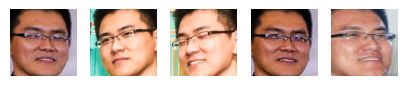

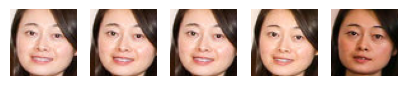

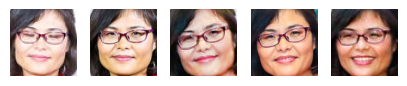

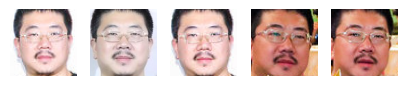

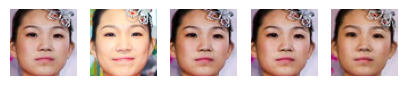

In [103]:
for x in range(5):
    cluster_0 = df[df['cluster'] == x]
    cluster_0 = cluster_0.reset_index(drop=True)

    fig, axes = plt.subplots(1, 5, figsize=(5, 5))

    for i, ax in enumerate(axes.flat):
        image = Image.open(cluster_0['img_path'][i])
        x, y, w, h = cluster_0['bounding_box'][i]
        face = image.crop((x, y, x+w, y+h))
        ax.imshow(face)
        ax.axis("off")

In [104]:
# For each cluster create a folder and save all the images in that cluster

for cluster in range(n_clusters_):
    cluster_path = f"result/cluster/clusters_ghostfacenet/cluster_{cluster}"
    os.makedirs(cluster_path, exist_ok=True)
    
    cluster_df = df[df['cluster'] == cluster]
    
    for i, row in cluster_df.iterrows():
        img_path = row['img_path']
        image = Image.open(img_path)
        x, y, w, h = row['bounding_box']
        face = image.crop((x, y, x+w, y+h))
        
        face.save(f"{cluster_path}/{i}.jpg")